In [1]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from utils import classification_metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bipinkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
train = pd.read_csv('./data/train.tsv', sep='\t')
# test = pd.read_csv('./data/test.tsv', sep='\t')

In [3]:
train.iloc[0]['Phrase'], train.iloc[0]['Sentiment']

('A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 1)

In [4]:
train.iloc[1]['Phrase'], train.iloc[1]['Sentiment']

('A series of escapades demonstrating the adage that what is good for the goose',
 2)

In [5]:
train.iloc[116]['Phrase'], train.iloc[116]['Sentiment']

('A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .',
 3)

In [6]:
train.iloc[63]['Phrase'], train.iloc[63]['Sentiment']

('This quiet , introspective and entertaining independent is worth seeking .',
 4)

## Converting the Y values to positive or negative

In [7]:
train['Output'] = list(map(lambda x: 'Positive' if x > 2 else 'Negative', train['Sentiment']))

In [9]:
def preprocess_all_review(x):
    line = re.sub(r'[^a-zA-Z ]+', ' ', str(x))
    line = line.lower()
    
    line = line.split()
    
    line = [word for word in line if not word in set(stopwords.words('english'))]
    
    line = ' '.join(line)
    return line

In [10]:
train['X'] = list(map(preprocess_all_review, train['Phrase']))

In [11]:
train.to_csv('./data/processed_data.csv')

In [2]:
train = pd.read_csv('./data/processed_data.csv')

In [3]:
train = train[['X', 'Output']]
train = train.dropna()

## Using count vectorizer

In [11]:
vectorizer = feature_extraction.text.CountVectorizer(stop_words = 'english', ngram_range=(1, 3))
X = vectorizer.fit_transform(train['X'])

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, train['Output'], test_size=0.2, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(123700, 129450), (30925, 129450)]


In [13]:
classifier = naive_bayes.MultinomialNB()
parameters = {'alpha':[0.01, 0.1, 0.5, 1, 2, 5]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'neg_log_loss',
                           cv = 3)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_cross_entropy_loss = grid_search.best_score_

In [14]:
best_cross_entropy_loss, best_parameters

(-0.499975879444914, {'alpha': 5})

In [16]:
bayes = naive_bayes.MultinomialNB(alpha = 5)
bayes.fit(X_train, y_train)

MultinomialNB(alpha=5, class_prior=None, fit_prior=True)

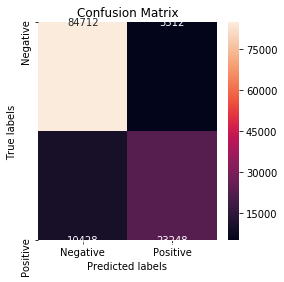

Train 

accuracy:     0.87 
sensitivity:  0.69 
specifity:    0.94
[[84712  5312]
 [10428 23248]]


In [17]:
classification_metrics(y_train, bayes.predict(X_train), msg = 'Train')

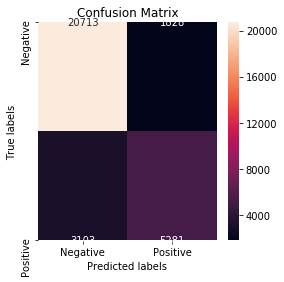

Test 

accuracy:     0.84 
sensitivity:  0.63 
specifity:    0.92
[[20713  1828]
 [ 3103  5281]]


In [18]:
classification_metrics(y_test, bayes.predict(X_test), msg = 'Test')

## The model is not overfitting but we can see it is not identifying the positive reviews corretly

## Usinf tf-idf

In [19]:
vectorizer = feature_extraction.text.TfidfVectorizer(stop_words = 'english', ngram_range=(1, 3))
X = vectorizer.fit_transform(train['X'])

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, train['Output'], test_size=0.2, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(123700, 129450), (30925, 129450)]


In [21]:
classifier = naive_bayes.MultinomialNB()
parameters = {'alpha':[0.01, 0.1, 0.5, 1, 2, 5]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'neg_log_loss',
                           cv = 3)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_cross_entropy_loss = grid_search.best_score_

In [22]:
best_cross_entropy_loss, best_parameters

(-0.3837447806325512, {'alpha': 0.5})

In [27]:
bayes = naive_bayes.MultinomialNB(alpha = 0.5)
bayes.fit(X_train, y_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

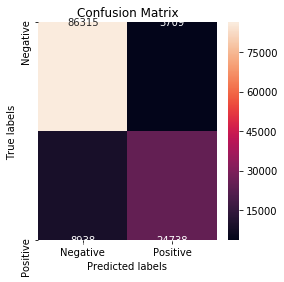

Train 

accuracy:     0.9 
sensitivity:  0.73 
specifity:    0.96
[[86315  3709]
 [ 8938 24738]]


In [28]:
classification_metrics(y_train, bayes.predict(X_train), msg = 'Train')

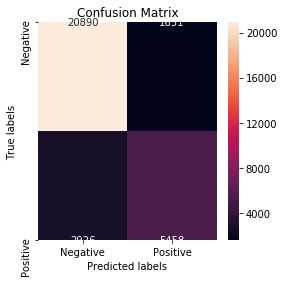

Test 

accuracy:     0.85 
sensitivity:  0.65 
specifity:    0.93
[[20890  1651]
 [ 2926  5458]]


In [29]:
classification_metrics(y_test, bayes.predict(X_test), msg = 'Test')

## Using Tf-idf there is slight improvement but not much